In [136]:
import statsmodels.formula.api as smf

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load data into pandas dataframe

songs_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

df = pd.read_csv(songs_url)

cleaned_df = df.groupby(['track_id']).first().reset_index()
cleaned_df.shape

cleaned_df_copy = cleaned_df.copy()

cleaned_df_copy['track_popularity_shift'] = np.where( cleaned_df_copy.track_popularity == 100, cleaned_df_copy.track_popularity - 0.1, cleaned_df_copy.track_popularity)
cleaned_df_copy['track_popularity_shift'] = np.where( cleaned_df_copy.track_popularity == 0, cleaned_df_copy.track_popularity + 0.1, cleaned_df_copy.track_popularity_shift )


continuous_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']


# iterate over each continuous variable and apply the shift logic
for col in continuous_columns:
    # shift values for 100
    cleaned_df_copy[f'{col}_shift'] = np.where(cleaned_df_copy[col] == 100, cleaned_df_copy[col] - 0.1, cleaned_df_copy[col])
    # shift values for 0
    cleaned_df_copy[f'{col}_shift'] = np.where(cleaned_df_copy[col] == 0, cleaned_df_copy[col] + 0.1, cleaned_df_copy[f'{col}_shift'])

final_df = cleaned_df_copy.copy()

final_df['track_popularity_frac'] = final_df.track_popularity_shift / 100
final_df['y'] = np.log( final_df.track_popularity_frac / (1 - final_df.track_popularity_frac) )
final_df.drop(columns='track_popularity_shift', inplace=True)
final_df.drop(columns='track_popularity_frac', inplace=True)

for col in continuous_columns:
    # divide by 100
    final_df[f'{col}_frac'] = final_df[f'{col}_shift'] / 100
    
    final_df[f'{col}_frac'] = np.clip(final_df[f'{col}_shift'], 1e-10, 1 - 1e-10)
    final_df.drop(columns=f'{col}_shift', inplace=True)
 
    # calculate logit transformation
    final_df[f'{col}_log'] = np.log(final_df[f'{col}_frac'] / (1 - final_df[f'{col}_frac']))
    
    
    final_df.drop(columns=f'{col}_frac', inplace=True)
    

final_df.describe()

track_popularity  danceability        energy           key  \
count      28356.000000  28356.000000  28356.000000  28356.000000   
mean          39.329771      0.653372      0.698388      5.368000   
std           23.702376      0.145785      0.183503      3.613904   
min            0.000000      0.000000      0.000175      0.000000   
25%           21.000000      0.561000      0.579000      2.000000   
50%           42.000000      0.670000      0.722000      6.000000   
75%           58.000000      0.760000      0.843000      9.000000   
max          100.000000      0.983000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  28356.000000  28356.000000  28356.000000  28356.000000   
mean      -6.817696      0.565489      0.107954      0.177176   
std        3.036243      0.495701      0.102556      0.222803   
min      -46.448000      0.000000      0.000000      0.000000   
25%       -8.309250      0.000000      0.041000      0.014375   
50%       -6.261000      1.000000      0.062600      0.079700   
75%       -4.709000      1.000000      0.133000      0.260000   
max        1.275000      1.000000      0.918000      0.994000   

       instrumentalness      liveness  ...    duration_ms             y  \
count      28356.000000  28356.000000  ...   28356.000000  28356.000000   
mean           0.091117      0.190958  ...  226575.967026     -1.032966   
std            0.232548      0.155894  ...   61078.450819      2.224323   
min            0.000000      0.000000  ...    4000.000000     -6.906755   
25%            0.000000      0.092600  ...  187742.000000     -1.324925   
50%            0.000021      0.127000  ...  216933.000000     -0.322773   
75%            0.006570      0.249000  ...  254975.250000      0.322773   
max            0.994000      0.996000  ...  517810.000000      6.906755   

       danceability_log    energy_log  loudness_log  speechiness_log  \
count      28356.000000  28356.000000  28356.000000     28356.000000   
mean           0.704743      1.044172    -23.019382        -2.439812   
std            0.715020      1.119592      0.472372         0.898125   
min           -2.482418     -8.650550    -23.025851        -3.776040   
25%            0.245221      0.318670    -23.025851        -3.152319   
50%            0.708185      0.954404    -23.025851        -2.706345   
75%            1.152680      1.680721    -23.025851        -1.874690   
max            4.057396     23.025851     23.025851         2.415478   

       acousticness_log  instrumentalness_log  liveness_log   valence_log  
count      28356.000000          28356.000000  28356.000000  28356.000000  
mean          -2.780104             -4.808263     -1.662601      0.059206  
std            2.515573              4.282268      0.955995      1.223527  
min          -13.479037            -13.815510     -4.661906    -11.512915  
25%           -4.226022             -8.381560     -2.282294     -0.712711  
50%           -2.446430             -2.197225     -1.927748      0.048009  
75%           -1.045969             -2.197225     -1.103953      0.823600  
max            5.109978              5.109978      5.517453      4.701490  

[8 rows x 22 columns]

In [138]:
def my_coefplot(mod, figsize_use=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize_use)
    
    ax.errorbar( y=mod.params.index,
                 x=mod.params,
                 xerr = 2 * mod.bse,
                 fmt='o', color='k', ecolor='k', elinewidth=1, ms=3)
    
    ax.axvline(x=0, linestyle='--', linewidth=1.5, color='grey')
    
    ax.set_xlabel('coefficient value')
    
    plt.show()

In [139]:
formula_list = ['y ~ 1',
                'y ~ playlist_genre',
                'y ~ danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log',
                'y ~ playlist_genre + danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log',
                'y ~ (danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log) ** 2',
                'y ~ (danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log) * playlist_genre',
                'y ~ (danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log) ** 3',
                'y ~ (danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log) ** 4'
                ]

In [140]:
model_metrics = {}

In [141]:
def fit_lm_regression(train_df, formula):
    
    print('-' * 120)
    print('\n\nLinear model formula = ', formula, '\n\n')
    
    mod = smf.ols(formula=formula, data=train_df).fit()
    print(mod.summary())

    significance_threshold = 0.05
    significant_coefficients = mod.pvalues[mod.pvalues < significance_threshold].index

    my_coefplot(mod)
    
    num_coefficients = len(mod.params)
    print("Number of coefficients estimated = ", num_coefficients)
    
    if len(significant_coefficients) > 0:
        print("\nStatistically Significant Coefficients:")
        print(mod.params[significant_coefficients])

        # positive and negative coefficients
        positive_coefficients = mod.params[mod.params > 0].index
        negative_coefficients = mod.params[mod.params < 0].index

        print("\nStatistically Significant Positive Coefficients:")
        print(mod.params[positive_coefficients])

        print("\nnStatistically Significant Negative Coefficients:")
        print(mod.params[negative_coefficients])

        # top two coefficients with the highest magnitude
        top_two_magnitude_coefficients = mod.params.abs().nlargest(2).index
        print("\nTop Two Magnitude Statistically Significant Coefficients:")
        print(mod.params[top_two_magnitude_coefficients])

    else:
        print("\nNo Significant Coefficients")
        
    # calculate and store R-squared and RMSE
    r_squared = mod.rsquared
    rmse = np.sqrt(mod.mse_resid)
    
    model_metrics[formula] = [r_squared, rmse]
    
    return mod

------------------------------------------------------------------------------------------------------------------------


Linear model formula =  y ~ 1 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 13 Dec 2023   Prob (F-statistic):                nan
Time:                        01:16:29   Log-Likelihood:                -62904.
No. Observations:               28356   AIC:                         1.258e+05
Df Residuals:                   28355   BIC:                         1.258e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|

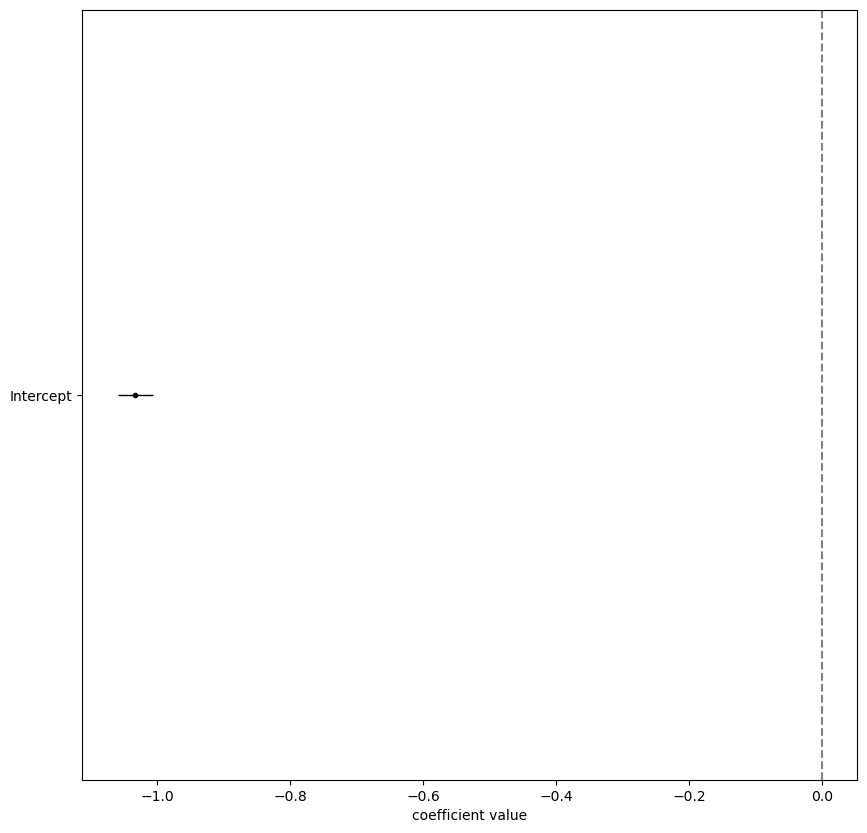

Number of coefficients estimated =  1

Statistically Significant Coefficients:
Intercept   -1.032966
dtype: float64

Statistically Significant Positive Coefficients:
Series([], dtype: float64)

nStatistically Significant Negative Coefficients:
Intercept   -1.032966
dtype: float64

Top Two Magnitude Statistically Significant Coefficients:
Intercept   -1.032966
dtype: float64
------------------------------------------------------------------------------------------------------------------------


Linear model formula =  y ~ playlist_genre 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     137.5
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          1.30e-144
Time:                        01:16:29   Log-Likelihood:    

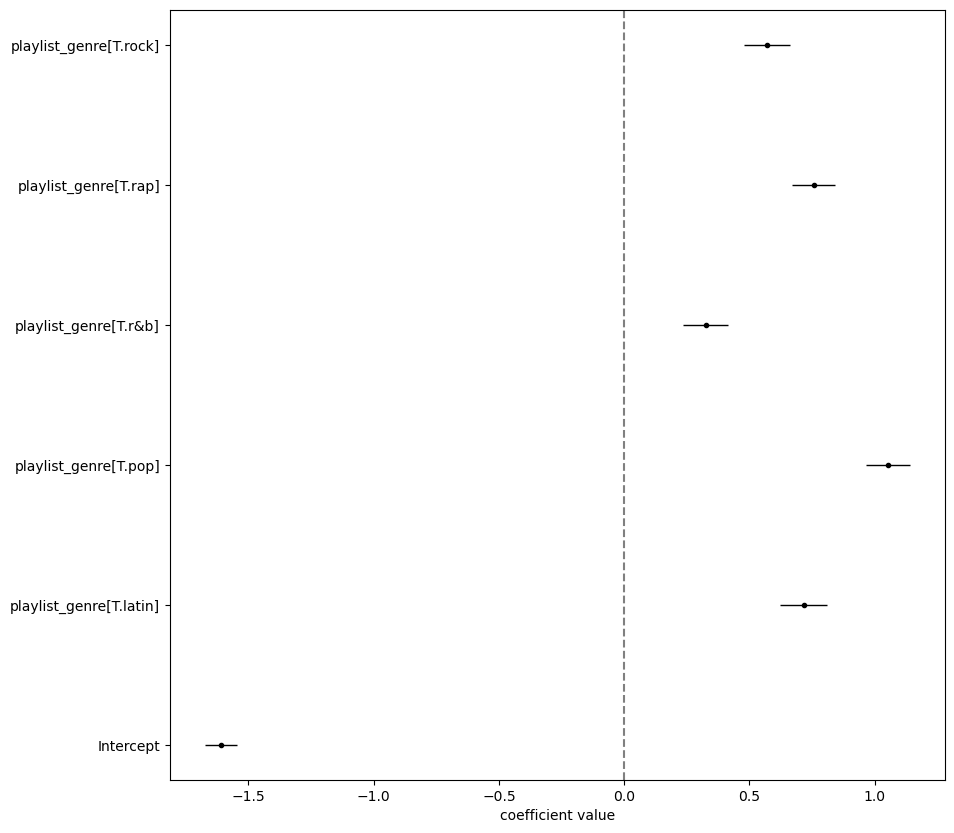

Number of coefficients estimated =  6

Statistically Significant Coefficients:
Intercept                 -1.610313
playlist_genre[T.latin]    0.717071
playlist_genre[T.pop]      1.052043
playlist_genre[T.r&b]      0.325124
playlist_genre[T.rap]      0.756322
playlist_genre[T.rock]     0.570590
dtype: float64

Statistically Significant Positive Coefficients:
playlist_genre[T.latin]    0.717071
playlist_genre[T.pop]      1.052043
playlist_genre[T.r&b]      0.325124
playlist_genre[T.rap]      0.756322
playlist_genre[T.rock]     0.570590
dtype: float64

nStatistically Significant Negative Coefficients:
Intercept   -1.610313
dtype: float64

Top Two Magnitude Statistically Significant Coefficients:
Intercept               -1.610313
playlist_genre[T.pop]    1.052043
dtype: float64
------------------------------------------------------------------------------------------------------------------------


Linear model formula =  y ~ danceability_log + energy_log + loudness_log + speechiness_log +

Number of coefficients estimated =  9

Statistically Significant Coefficients:
Intercept              -1.689519
danceability_log        0.099015
energy_log             -0.113206
acousticness_log        0.068087
instrumentalness_log   -0.019150
liveness_log           -0.061795
valence_log            -0.027285
dtype: float64

Statistically Significant Positive Coefficients:
danceability_log    0.099015
acousticness_log    0.068087
dtype: float64

nStatistically Significant Negative Coefficients:
Intercept              -1.689519
energy_log             -0.113206
loudness_log           -0.028204
speechiness_log        -0.021244
instrumentalness_log   -0.019150
liveness_log           -0.061795
valence_log            -0.027285
dtype: float64

Top Two Magnitude Statistically Significant Coefficients:
Intercept    -1.689519
energy_log   -0.113206
dtype: float64
------------------------------------------------------------------------------------------------------------------------


Linear model

Number of coefficients estimated =  14

Statistically Significant Coefficients:
Intercept                 -2.080923
playlist_genre[T.latin]    0.498435
playlist_genre[T.pop]      0.898821
playlist_genre[T.rap]      0.491360
playlist_genre[T.rock]     0.619452
danceability_log           0.162616
energy_log                -0.100364
acousticness_log           0.066839
instrumentalness_log      -0.014812
liveness_log              -0.054324
valence_log               -0.065479
dtype: float64

Statistically Significant Positive Coefficients:
playlist_genre[T.latin]    0.498435
playlist_genre[T.pop]      0.898821
playlist_genre[T.r&b]      0.025280
playlist_genre[T.rap]      0.491360
playlist_genre[T.rock]     0.619452
danceability_log           0.162616
speechiness_log            0.004032
acousticness_log           0.066839
dtype: float64

nStatistically Significant Negative Coefficients:
Intercept              -2.080923
energy_log             -0.100364
loudness_log           -0.028198
instru

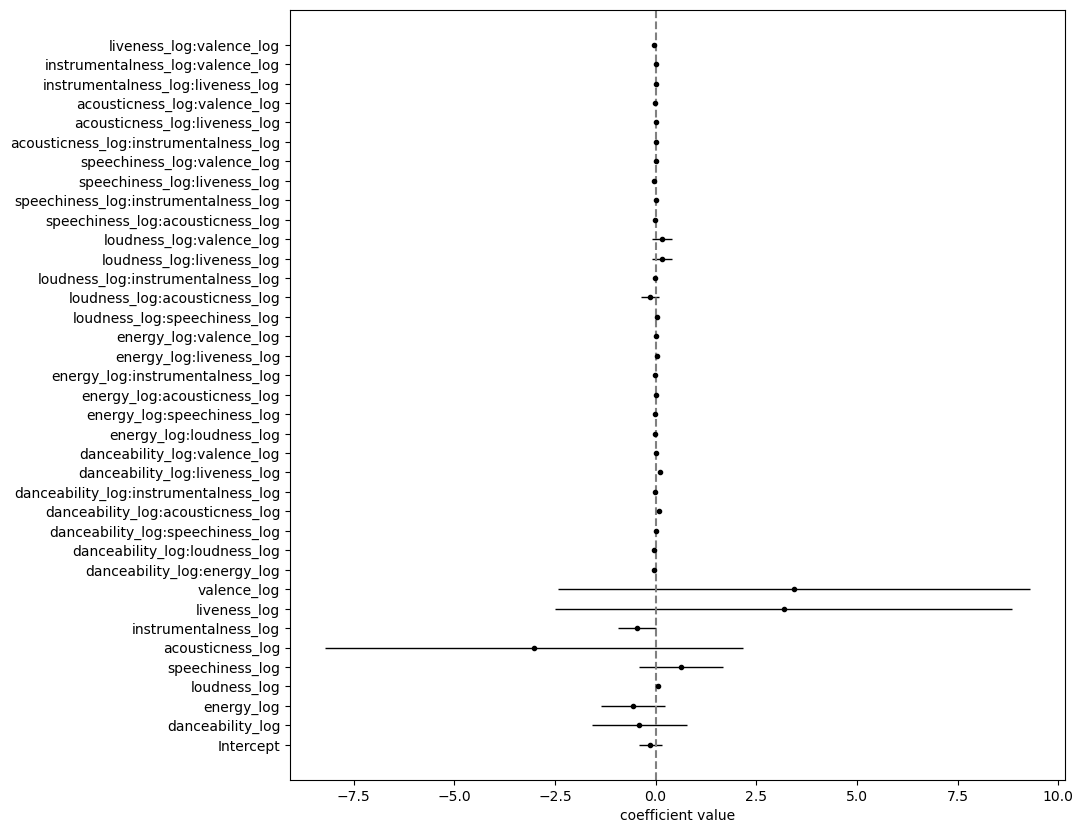

Number of coefficients estimated =  37

Statistically Significant Coefficients:
loudness_log                             0.056653
instrumentalness_log                    -0.462968
danceability_log:acousticness_log        0.075048
danceability_log:liveness_log            0.112115
energy_log:instrumentalness_log         -0.006512
energy_log:liveness_log                  0.032402
loudness_log:instrumentalness_log       -0.020849
speechiness_log:liveness_log            -0.038533
acousticness_log:instrumentalness_log    0.005608
acousticness_log:valence_log            -0.021989
liveness_log:valence_log                -0.031878
dtype: float64

Statistically Significant Positive Coefficients:
loudness_log                             0.056653
speechiness_log                          0.629803
liveness_log                             3.177739
valence_log                              3.436452
danceability_log:speechiness_log         0.003791
danceability_log:acousticness_log        0.075048
dance

Number of coefficients estimated =  54

Statistically Significant Coefficients:
Intercept                                  -2.663270
playlist_genre[T.pop]                       0.002123
playlist_genre[T.r&b]                      -0.001075
danceability_log:playlist_genre[T.pop]      0.176709
danceability_log:playlist_genre[T.rap]      0.183768
danceability_log:playlist_genre[T.rock]     0.246118
energy_log:playlist_genre[T.pop]           -0.173823
energy_log:playlist_genre[T.r&b]           -0.117696
energy_log:playlist_genre[T.rap]           -0.166112
loudness_log:playlist_genre[T.pop]         -0.048873
loudness_log:playlist_genre[T.r&b]          0.024744
speechiness_log:playlist_genre[T.pop]       0.235032
speechiness_log:playlist_genre[T.rap]      -0.212144
acousticness_log                            0.154645
acousticness_log:playlist_genre[T.latin]    0.051288
acousticness_log:playlist_genre[T.pop]     -0.109200
acousticness_log:playlist_genre[T.r&b]     -0.100542
acousticness_log:pl

Number of coefficients estimated =  93

Statistically Significant Coefficients:
loudness_log                                         0.038622
danceability_log:energy_log                         -0.069192
energy_log:loudness_log                              0.014797
loudness_log:acousticness_log                       -0.010074
danceability_log:energy_log:loudness_log            -0.007581
danceability_log:energy_log:acousticness_log         0.025936
danceability_log:loudness_log:speechiness_log        0.021601
danceability_log:speechiness_log:acousticness_log   -0.024920
danceability_log:speechiness_log:liveness_log       -0.092422
danceability_log:liveness_log:valence_log            0.029373
energy_log:loudness_log:speechiness_log              0.008514
energy_log:speechiness_log:acousticness_log         -0.022400
energy_log:acousticness_log:liveness_log            -0.010383
energy_log:acousticness_log:valence_log             -0.011316
energy_log:instrumentalness_log:valence_log         

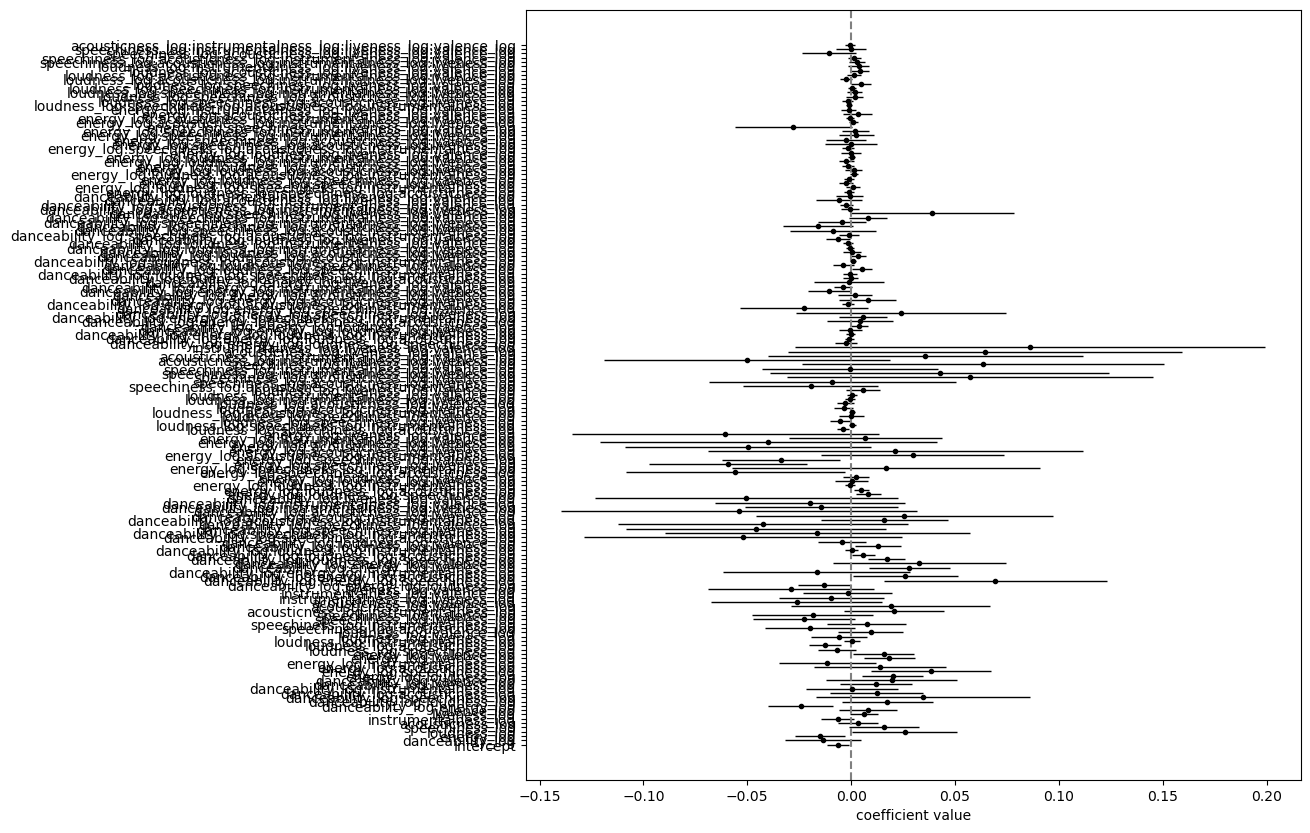

Number of coefficients estimated =  163

Statistically Significant Coefficients:
Intercept                                                       -0.006354
energy_log                                                      -0.014993
loudness_log                                                     0.025743
danceability_log:energy_log                                     -0.024318
energy_log:loudness_log                                          0.020087
energy_log:speechiness_log                                       0.038443
energy_log:liveness_log                                          0.018435
energy_log:valence_log                                           0.015711
loudness_log:acousticness_log                                   -0.012715
danceability_log:energy_log:loudness_log                        -0.012870
danceability_log:energy_log:speechiness_log                      0.069405
danceability_log:energy_log:acousticness_log                     0.026066
danceability_log:energy_log:liv

In [142]:
for formula in formula_list:
    fit_lm_regression(final_df, formula)

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
sns.scatterplot(x='danceability_log', y='y', data=final_df)
plt.title('Scatter Plot of Independent vs. Dependent Variable')
plt.xlabel('Independent Variable')
plt.ylabel('Dependent Variable')
plt.show()


In [144]:
final_df.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'y', 'danceability_log', 'energy_log', 'loudness_log',
       'speechiness_log', 'acousticness_log', 'instrumentalness_log',
       'liveness_log', 'valence_log'],
      dtype='object')

#### Predictions

#### Visualization Grid 1

In [228]:
input_grid_1 = pd.DataFrame([(
                              final_df['playlist_genre'].mode().iloc[0],
                              final_df['danceability_log'].median(),
                              final_df['loudness_log'].median(),
                              energy_log,
                              final_df['acousticness_log'].median(),
                              final_df['speechiness_log'].median(),
                              final_df['instrumentalness_log'].median(),
                              final_df['liveness_log'].median(),
                              final_df['valence_log'].median()
                              )
                              for energy_log in np.linspace(final_df['energy_log'].min(), final_df['energy_log'].max(), num=101)], 
                              columns=['playlist_genre', 'danceability_log', 'loudness_log', 'energy_log', 'acousticness_log', 'speechiness_log', 'instrumentalness_log', 'liveness_log', 'valence_log'])

In [229]:
input_grid_1.shape

(101, 9)

In [230]:
input_grid_1.nunique()

playlist_genre            1
danceability_log          1
loudness_log              1
energy_log              101
acousticness_log          1
speechiness_log           1
instrumentalness_log      1
liveness_log              1
valence_log               1
dtype: int64

In [231]:
input_grid_1

playlist_genre  danceability_log  loudness_log  energy_log  \
0              rap          0.708185    -23.025851   -8.650550   
1              rap          0.708185    -23.025851   -8.333786   
2              rap          0.708185    -23.025851   -8.017022   
3              rap          0.708185    -23.025851   -7.700258   
4              rap          0.708185    -23.025851   -7.383494   
..             ...               ...           ...         ...   
96             rap          0.708185    -23.025851   21.758795   
97             rap          0.708185    -23.025851   22.075559   
98             rap          0.708185    -23.025851   22.392323   
99             rap          0.708185    -23.025851   22.709087   
100            rap          0.708185    -23.025851   23.025851   

     acousticness_log  speechiness_log  instrumentalness_log  liveness_log  \
0            -2.44643        -2.706345             -2.197225     -1.927748   
1            -2.44643        -2.706345             -2.197225     -1.927748   
2            -2.44643        -2.706345             -2.197225     -1.927748   
3            -2.44643        -2.706345             -2.197225     -1.927748   
4            -2.44643        -2.706345             -2.197225     -1.927748   
..                ...              ...                   ...           ...   
96           -2.44643        -2.706345             -2.197225     -1.927748   
97           -2.44643        -2.706345             -2.197225     -1.927748   
98           -2.44643        -2.706345             -2.197225     -1.927748   
99           -2.44643        -2.706345             -2.197225     -1.927748   
100          -2.44643        -2.706345             -2.197225     -1.927748   

     valence_log  
0       0.048009  
1       0.048009  
2       0.048009  
3       0.048009  
4       0.048009  
..           ...  
96      0.048009  
97      0.048009  
98      0.048009  
99      0.048009  
100     0.048009  

[101 rows x 9 columns]

------------------------------------------------------------------------------------------------------------------------


Linear model formula =  y ~ playlist_genre + danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     88.89
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          4.90e-234
Time:                        01:38:00   Log-Likelihood:                -62338.
No. Observations:               28356   AIC:                         1.247e+05
Df Residuals:                   28342   BIC:                         1.248e+05
Df Model:                          13                          

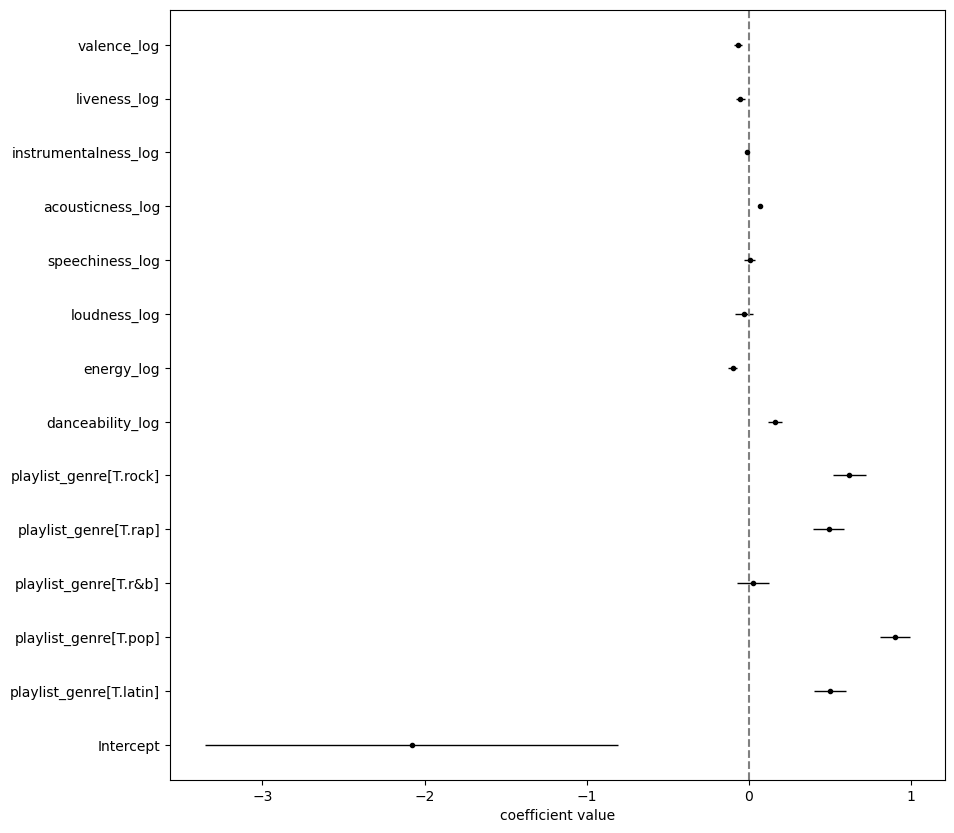

Number of coefficients estimated =  14

Statistically Significant Coefficients:
Intercept                 -2.080923
playlist_genre[T.latin]    0.498435
playlist_genre[T.pop]      0.898821
playlist_genre[T.rap]      0.491360
playlist_genre[T.rock]     0.619452
danceability_log           0.162616
energy_log                -0.100364
acousticness_log           0.066839
instrumentalness_log      -0.014812
liveness_log              -0.054324
valence_log               -0.065479
dtype: float64

Statistically Significant Positive Coefficients:
playlist_genre[T.latin]    0.498435
playlist_genre[T.pop]      0.898821
playlist_genre[T.r&b]      0.025280
playlist_genre[T.rap]      0.491360
playlist_genre[T.rock]     0.619452
danceability_log           0.162616
speechiness_log            0.004032
acousticness_log           0.066839
dtype: float64

nStatistically Significant Negative Coefficients:
Intercept              -2.080923
energy_log             -0.100364
loudness_log           -0.028198
instru

In [232]:
fit_all_mod = fit_lm_regression(final_df, 'y ~ playlist_genre + danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log')

------------------------------------------------------------------------------------------------------------------------


Linear model formula =  y ~ (danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log) * playlist_genre 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     32.81
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          2.10e-301
Time:                        01:43:38   Log-Likelihood:                -62105.
No. Observations:               28356   AIC:                         1.243e+05
Df Residuals:                   28305   BIC:                         1.247e+05
Df Model:                          50                        

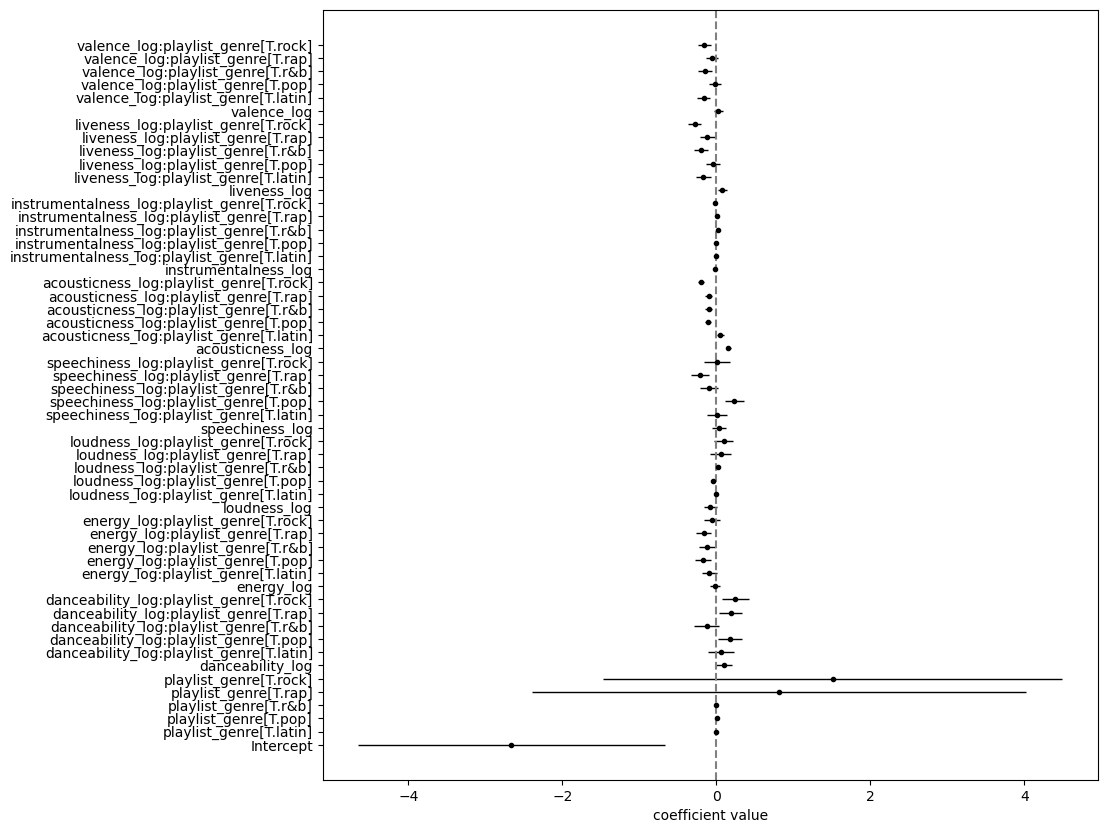

Number of coefficients estimated =  54

Statistically Significant Coefficients:
Intercept                                  -2.663270
playlist_genre[T.pop]                       0.002123
playlist_genre[T.r&b]                      -0.001075
danceability_log:playlist_genre[T.pop]      0.176709
danceability_log:playlist_genre[T.rap]      0.183768
danceability_log:playlist_genre[T.rock]     0.246118
energy_log:playlist_genre[T.pop]           -0.173823
energy_log:playlist_genre[T.r&b]           -0.117696
energy_log:playlist_genre[T.rap]           -0.166112
loudness_log:playlist_genre[T.pop]         -0.048873
loudness_log:playlist_genre[T.r&b]          0.024744
speechiness_log:playlist_genre[T.pop]       0.235032
speechiness_log:playlist_genre[T.rap]      -0.212144
acousticness_log                            0.154645
acousticness_log:playlist_genre[T.latin]    0.051288
acousticness_log:playlist_genre[T.pop]     -0.109200
acousticness_log:playlist_genre[T.r&b]     -0.100542
acousticness_log:pl

In [243]:
fit_pair_mod = fit_lm_regression(final_df, 'y ~ (danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log) * playlist_genre')

In [244]:
dfviz_1['pred_pair'] = fit_pair_mod.predict( input_grid_1 )

In [245]:
dfviz_1.head()

playlist_genre  danceability_log  loudness_log  energy_log  \
0            rap          0.708185    -23.025851   -8.650550   
1            rap          0.708185    -23.025851   -8.333786   
2            rap          0.708185    -23.025851   -8.017022   
3            rap          0.708185    -23.025851   -7.700258   
4            rap          0.708185    -23.025851   -7.383494   

   acousticness_log  speechiness_log  instrumentalness_log  liveness_log  \
0          -2.44643        -2.706345             -2.197225     -1.927748   
1          -2.44643        -2.706345             -2.197225     -1.927748   
2          -2.44643        -2.706345             -2.197225     -1.927748   
3          -2.44643        -2.706345             -2.197225     -1.927748   
4          -2.44643        -2.706345             -2.197225     -1.927748   

   valence_log  pred_all  pred_pair  
0     0.048009  0.002786   0.986375  
1     0.048009 -0.029006   0.927239  
2     0.048009 -0.060798   0.868102  
3     0.048009 -0.092589   0.808965  
4     0.048009 -0.124381   0.749829

In [246]:
predictions = fit_pair_mod.get_prediction( dfviz_1 )

In [247]:
type( predictions )

statsmodels.regression._prediction.PredictionResults

In [248]:
fit_pair_mod_summary = predictions.summary_frame()

In [249]:
type( fit_pair_mod_summary )

pandas.core.frame.DataFrame

In [250]:
fit_pair_mod_summary

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0    0.986375  0.346836       0.306560       1.666191     -3.310177   
1    0.927239  0.335349       0.269938       1.584540     -3.365809   
2    0.868102  0.323871       0.233299       1.502905     -3.421559   
3    0.808965  0.312402       0.196642       1.421289     -3.477426   
4    0.749829  0.300944       0.159965       1.339693     -3.533412   
..        ...       ...            ...            ...           ...   
96  -4.690738  0.772185      -6.204257      -3.177218     -9.195064   
97  -4.749874  0.783767      -6.286096      -3.213652     -9.261880   
98  -4.809011  0.795350      -6.367936      -3.250086     -9.328797   
99  -4.868147  0.806934      -6.449777      -3.286518     -9.395814   
100 -4.927284  0.818518      -6.531619      -3.322949     -9.462932   

     obs_ci_upper  
0        5.282928  
1        5.220287  
2        5.157763  
3        5.095357  
4        5.033070  
..            ...  
96      -0.186411  
97      -0.237869  
98      -0.289225  
99      -0.340480  
100     -0.391635  

[101 rows x 6 columns]

In [251]:
fig, ax = plt.subplots()

# prediction interval - the uncertainty on a single measurement (observation)
ax.fill_between( dfviz_1.energy_log,
                 fit_all_mod_summary.obs_ci_lower, fit_all_mod_summary.obs_ci_upper,
                 facecolor='orange', alpha=0.75, edgecolor='orange')

# confidence interval - the uncertainty on the mean output
ax.fill_between( dfviz_1.energy_log,
                 fit_all_mod_summary.mean_ci_lower, fit_all_mod_summary.mean_ci_upper,
                 facecolor='grey', edgecolor='grey' )

# output mean - the predictive trend - the best fit line
ax.plot( dfviz_1.energy_log, fit_all_mod_summary['mean'], color='k', linewidth=1.5)

# include the training data
ax.scatter( final_df.energy_log, final_df.y, color='k', s=1 )

# set the labels
ax.set_xlabel('energy_log')
ax.set_ylabel('y')

# show the plot
plt.show()

------------------------------------------------------------------------------------------------------------------------


Linear model formula =  y ~ playlist_genre + danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     88.89
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          4.90e-234
Time:                        01:38:00   Log-Likelihood:                -62338.
No. Observations:               28356   AIC:                         1.247e+05
Df Residuals:                   28342   BIC:                         1.248e+05
Df Model:                          13                          

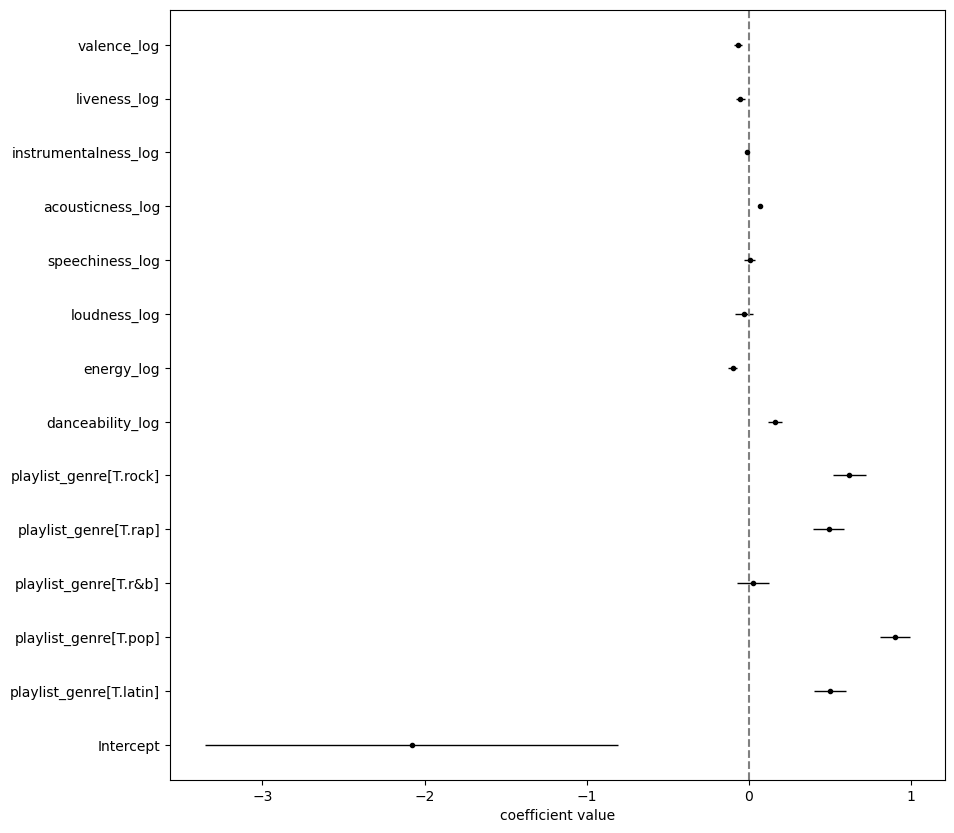

Number of coefficients estimated =  14

Statistically Significant Coefficients:
Intercept                 -2.080923
playlist_genre[T.latin]    0.498435
playlist_genre[T.pop]      0.898821
playlist_genre[T.rap]      0.491360
playlist_genre[T.rock]     0.619452
danceability_log           0.162616
energy_log                -0.100364
acousticness_log           0.066839
instrumentalness_log      -0.014812
liveness_log              -0.054324
valence_log               -0.065479
dtype: float64

Statistically Significant Positive Coefficients:
playlist_genre[T.latin]    0.498435
playlist_genre[T.pop]      0.898821
playlist_genre[T.r&b]      0.025280
playlist_genre[T.rap]      0.491360
playlist_genre[T.rock]     0.619452
danceability_log           0.162616
speechiness_log            0.004032
acousticness_log           0.066839
dtype: float64

nStatistically Significant Negative Coefficients:
Intercept              -2.080923
energy_log             -0.100364
loudness_log           -0.028198
instru

In [232]:
fit_all_mod = fit_lm_regression(final_df, 'y ~ playlist_genre + danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log')

In [233]:
dfviz_1 = input_grid_1.copy()

In [234]:
dfviz_1['pred_all'] = fit_all_mod.predict( input_grid_1 )

In [235]:
dfviz_1.head()

playlist_genre  danceability_log  loudness_log  energy_log  \
0            rap          0.708185    -23.025851   -8.650550   
1            rap          0.708185    -23.025851   -8.333786   
2            rap          0.708185    -23.025851   -8.017022   
3            rap          0.708185    -23.025851   -7.700258   
4            rap          0.708185    -23.025851   -7.383494   

   acousticness_log  speechiness_log  instrumentalness_log  liveness_log  \
0          -2.44643        -2.706345             -2.197225     -1.927748   
1          -2.44643        -2.706345             -2.197225     -1.927748   
2          -2.44643        -2.706345             -2.197225     -1.927748   
3          -2.44643        -2.706345             -2.197225     -1.927748   
4          -2.44643        -2.706345             -2.197225     -1.927748   

   valence_log  pred_all  
0     0.048009  0.002786  
1     0.048009 -0.029006  
2     0.048009 -0.060798  
3     0.048009 -0.092589  
4     0.048009 -0.124381

In [252]:
predictions = fit_all_mod.get_prediction( dfviz_1 )

In [253]:
type( predictions )

statsmodels.regression._prediction.PredictionResults

In [254]:
fit_all_mod_summary = predictions.summary_frame()

In [255]:
type( fit_all_mod_summary )

pandas.core.frame.DataFrame

In [240]:
fit_all_mod_summary

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0    0.002786  0.139534      -0.270707       0.276279     -4.280462   
1   -0.029006  0.135085      -0.293779       0.235767     -4.311706   
2   -0.060798  0.130647      -0.316871       0.195276     -4.342969   
3   -0.092589  0.126221      -0.339988       0.154809     -4.374250   
4   -0.124381  0.121808      -0.363130       0.114368     -4.405551   
..        ...       ...            ...            ...           ...   
96  -3.049217  0.309229      -3.655321      -2.443113     -7.366482   
97  -3.081009  0.313805      -3.696081      -2.465937     -7.399542   
98  -3.112800  0.318381      -3.736842      -2.488759     -7.432620   
99  -3.144592  0.322958      -3.777606      -2.511579     -7.465717   
100 -3.176384  0.327536      -3.818370      -2.534397     -7.498833   

     obs_ci_upper  
0        4.286034  
1        4.253694  
2        4.221374  
3        4.189072  
4        4.156789  
..            ...  
96       1.268048  
97       1.237524  
98       1.207019  
99       1.176533  
100      1.146065  

[101 rows x 6 columns]

In [241]:
fig, ax = plt.subplots()

# prediction interval - the uncertainty on a single measurement (observation)
ax.fill_between( dfviz_1.energy_log,
                 fit_all_mod_summary.obs_ci_lower, fit_all_mod_summary.obs_ci_upper,
                 facecolor='orange', alpha=0.75, edgecolor='orange')

# confidence interval - the uncertainty on the mean output
ax.fill_between( dfviz_1.energy_log,
                 fit_all_mod_summary.mean_ci_lower, fit_all_mod_summary.mean_ci_upper,
                 facecolor='grey', edgecolor='grey' )

# output mean - the predictive trend - the best fit line
ax.plot( dfviz_1.energy_log, fit_all_mod_summary['mean'], color='k', linewidth=1.5)

# include the training data
ax.scatter( final_df.energy_log, final_df.y, color='k', s=1 )

# set the labels
ax.set_xlabel('energy_log')
ax.set_ylabel('y')

# show the plot
plt.show()

#### Visualization Grid 2